In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Set Seed
torch.manual_seed(22)

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load Data

In [2]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

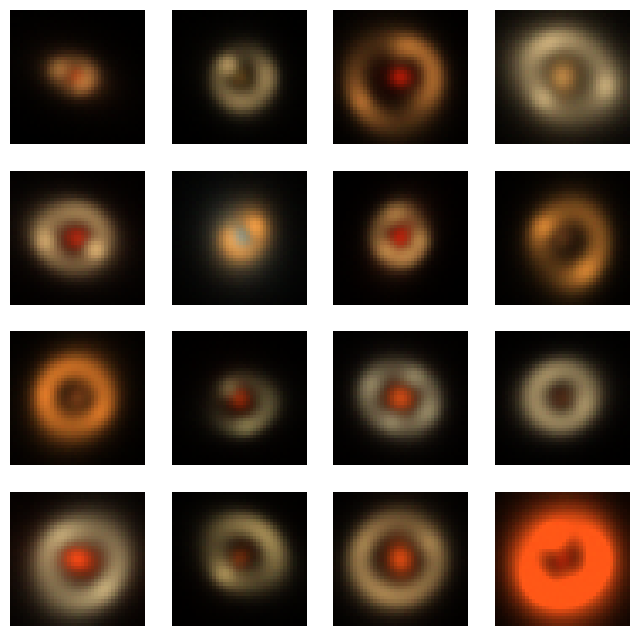

In [3]:
# Visualize source data
visualize_data(source_data)

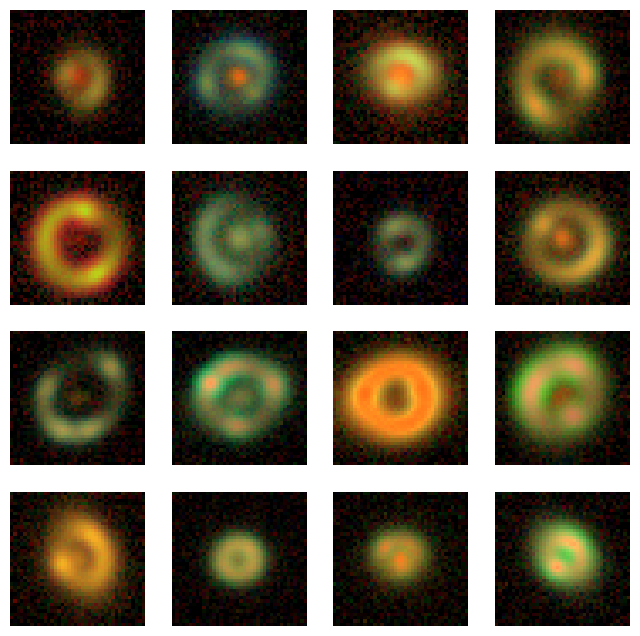

In [4]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [5]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    return da_weight

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    beta_val = beta_init - (beta_init - beta_final) * (2 * epoch / n_epoch)
    if ((epoch / n_epoch) > 0.5):
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 2e-5
n_epoch = 75
init_wt_da = 1.4
final_wt_da = 1.0
beta_init = 1.0
beta_final = 0.4

In [6]:
# Initialize model
#model = NeuralNetworkMVEv2(npix=40).cuda()
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
from torchsummary import summary

In [8]:
summary(model, (3, 40, 40))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

## Visualize Results

In [9]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_noda_v3_aug22_2300_B_mve"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [10]:
pd_stats = pd.DataFrame(stats)

In [11]:
pd_stats

,train_DA_loss,train_regression_loss,train_mve_loss,train_r2_score,val_source_regression_loss,val_target_regression_loss,val_source_r2_score,val_target_r2_score,val_source_mve_loss,val_target_mve_loss,da_weight,beta,epoch_no,lr
0,0.331095,2.465360,1.080043,-6.487281,1.793795,1.729979,-4.552167,-4.179793,0.723277,0.688115,0.0,1.000,84,[1e-05]
1,0.332839,1.314950,0.486562,-2.977910,0.924131,0.894468,-1.827414,-1.661112,0.291778,0.278007,0.0,0.996,84,[1e-05]
2,0.333293,0.692723,0.177891,-1.096396,0.506863,0.519380,-0.554976,-0.539011,0.084893,0.093423,0.0,0.992,84,[1e-05]
3,0.333017,0.422767,0.041449,-0.279863,0.353176,0.380314,-0.081323,-0.126222,0.004046,0.020700,0.0,0.988,84,[1e-05]
4,0.337513,0.318033,-0.015776,0.039327,0.281346,0.324272,0.140981,0.042182,-0.036808,-0.013104,0.0,0.984,84,[1e-05]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.322123,0.014719,-0.211944,0.955412,0.014976,0.159967,0.953985,0.524701,-0.209237,-0.034903,0.0,0.684,84,[1e-05]
80,0.321730,0.014625,-0.214231,0.955709,0.014825,0.164730,0.954484,0.507709,-0.212210,-0.060237,0.0,0.680,84,[1e-05]
81,0.321536,0.014587,-0.199787,0.955776,0.014866,0.157834,0.954329,0.530789,-0.179359,0.106632,0.0,0.676,84,[1e-05]
82,0.320815,0.014429,-0.182752,0.956246,0.015261,0.162645,0.953270,0.519548,-0.155781,0.239561,0.0,0.672,84,[1e-05]


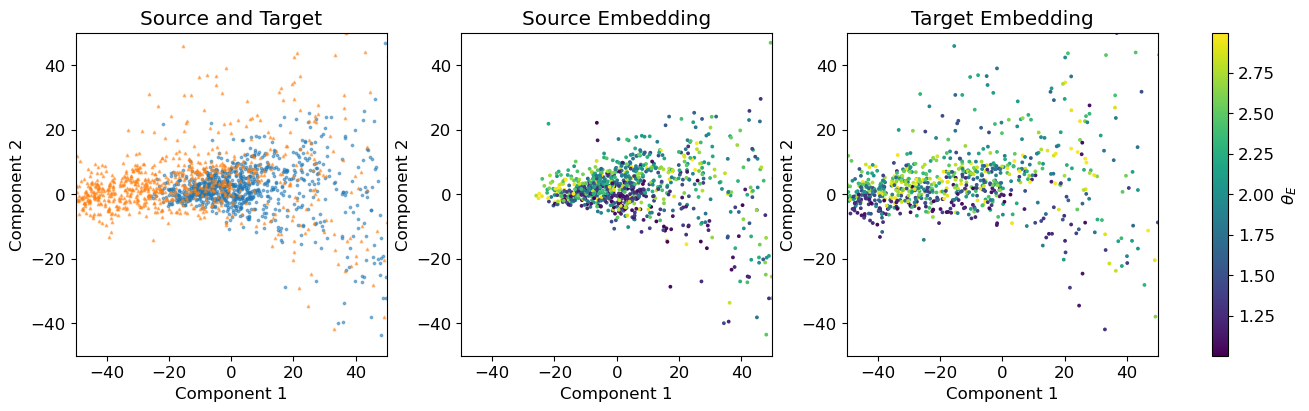

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [12]:
# Visualize isomaps 
plt.rcParams.update({'font.size': 12})
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

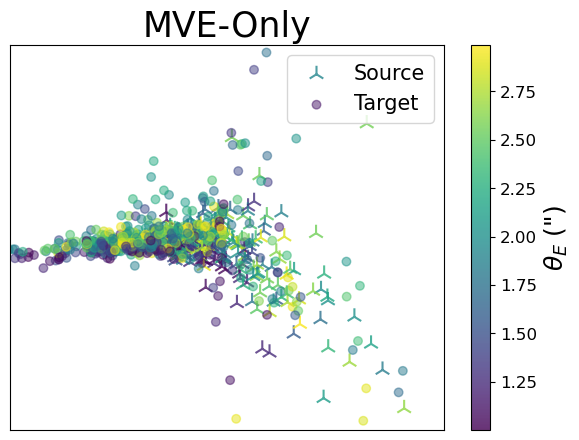

In [46]:
axlim = 130
cx = 30
cy = 5
n = 500
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5),)
s = ax1.scatter(trained_source_iso[:, 0][:n], trained_source_iso[:, 1][:n], s=150, marker='2', alpha = 0.8, c = isomap_source_label_sample[:n], 
           label = "Source")
ax1.scatter(trained_target_iso[:, 0][:n], trained_target_iso[:, 1][:n], s=150, marker='.', alpha = 0.5, c = isomap_target_label_sample[:n],
           label = "Target")
ax1.set_xlim(-axlim + cx, axlim + cx)
ax1.set_ylim(-axlim + cy, axlim + cy)
ax1.set_title('MVE-Only', fontsize = 25)

# Remove axis ticks and labels
# xl, xr = ax1.get_xlim()
# yl, yr = ax1.get_ylim()
# xt = np.int32(np.linspace(xl, xr, 5))
# yt = np.int32(np.linspace(yl, yr, 5))

# ax1.set_xticks(xt)
# ax1.set_yticks(yt)
# ax1.set_xticklabels(xt)
# ax1.set_yticklabels(yt)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xticklabels([])
ax1.set_yticklabels([])
plt.legend(fontsize = 15)
cbar = plt.colorbar(s, ax = ax1)
cbar.set_label("$\\theta_E$ (\")",size=18)
cbar.ax.tick_params(labelsize=12) #.set_label(label = "$\\theta_E$ (\")", labelsize=18)
plt.savefig("post_isomap_noda.png", bbox_inches = 'tight', dpi = 400)

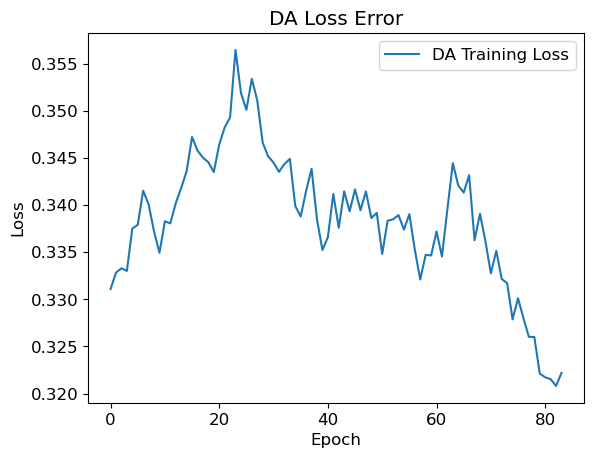

In [14]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
#plt.ylim(0.01, 0.03)
#plt.xlim(200, 300)

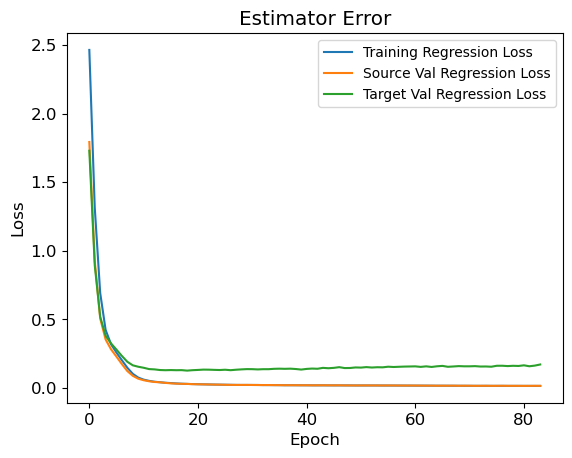

In [15]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
#plt.ylim(0, 0.10)

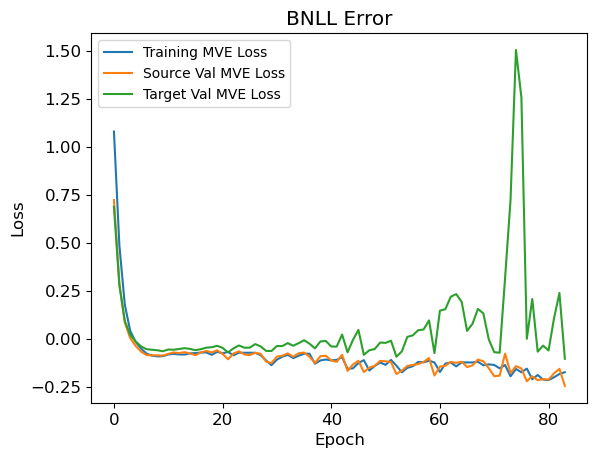

In [16]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
# plt.ylim(-2, 2)
# plt.xlim(100, 300)
# plt.ylim(-2, 30)

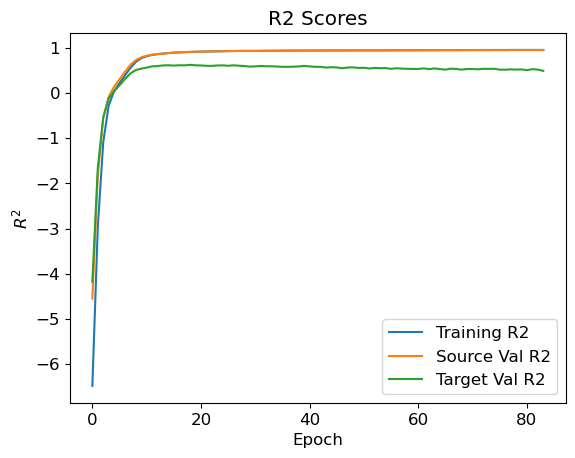

In [17]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
#plt.ylim(0.7, 1)
# plt.xlim(200, 300)
# plt.ylim(0.9, 1)

In [18]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9552


Text(0.5, 1.0, 'MMD | Source | R2: 0.955')

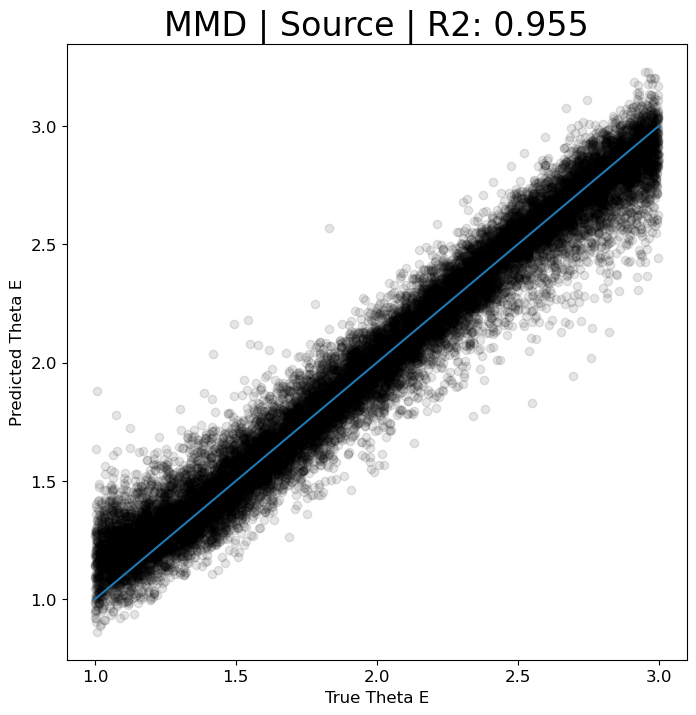

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.955')

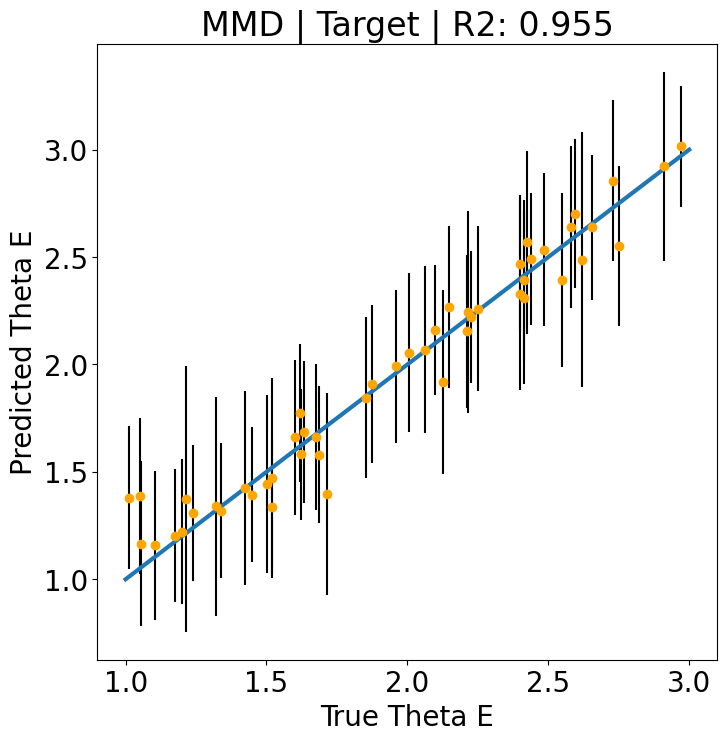

In [20]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_source)), 50)
plt.errorbar(true_source[idx], preds_source[idx], yerr = np.sqrt(var_preds_source[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.341')

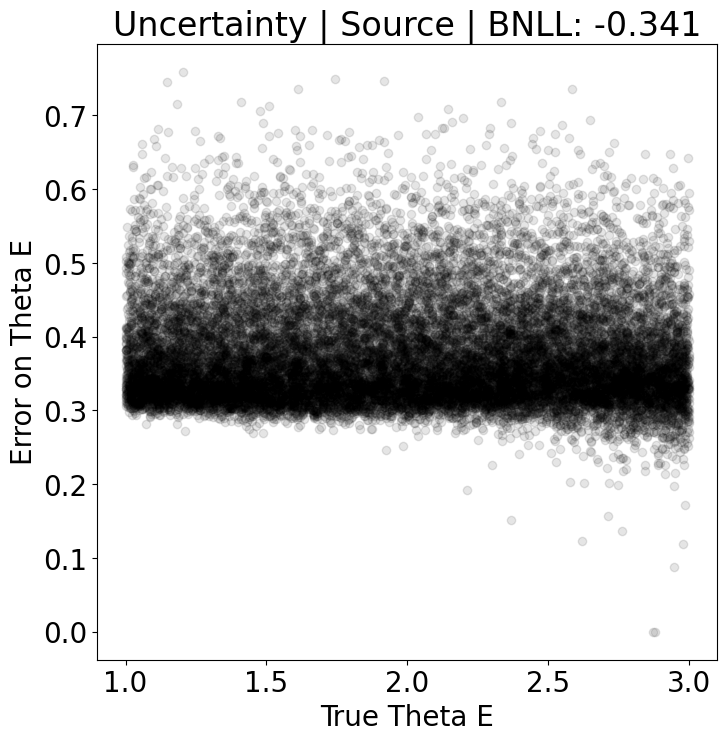

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [22]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.4869


Text(0.5, 1.0, 'MMD | Target | R2: 0.487')

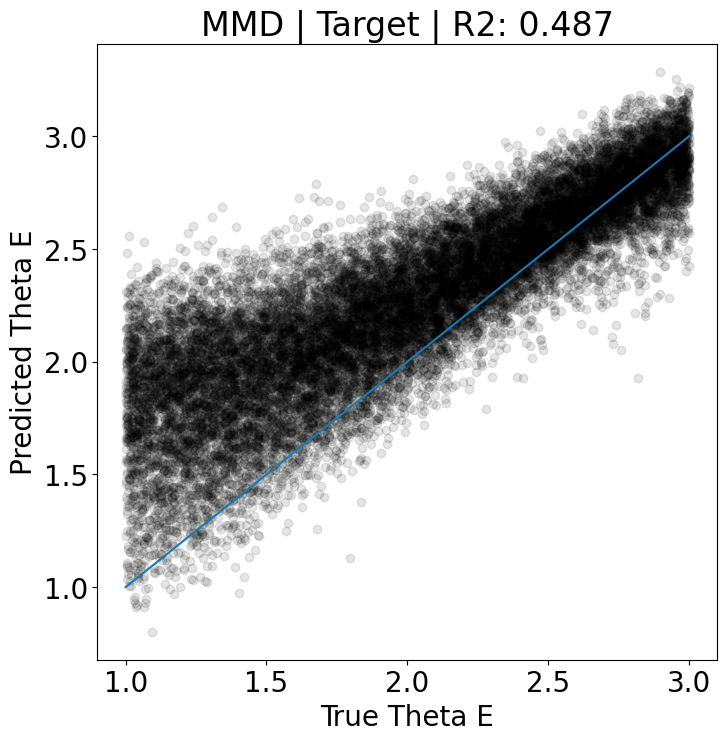

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.487')

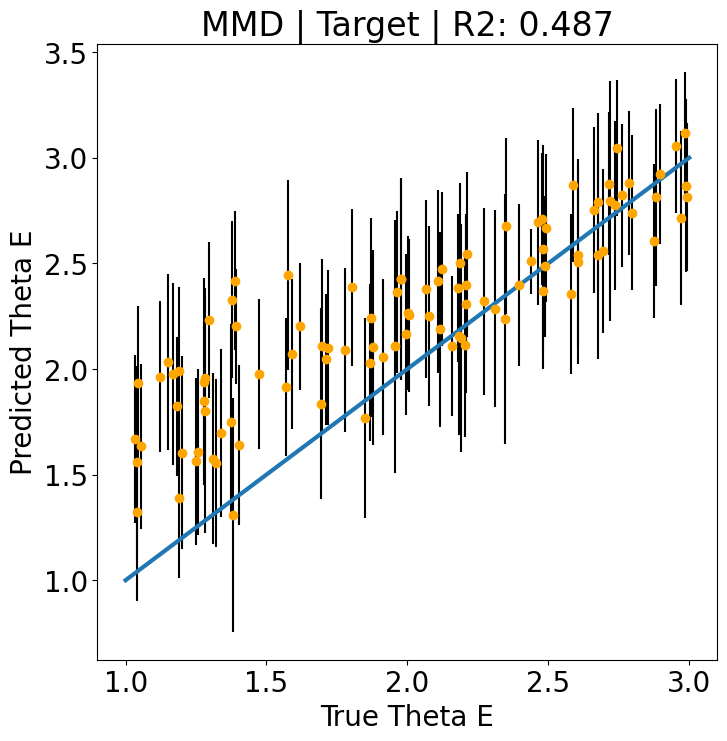

In [24]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.115')

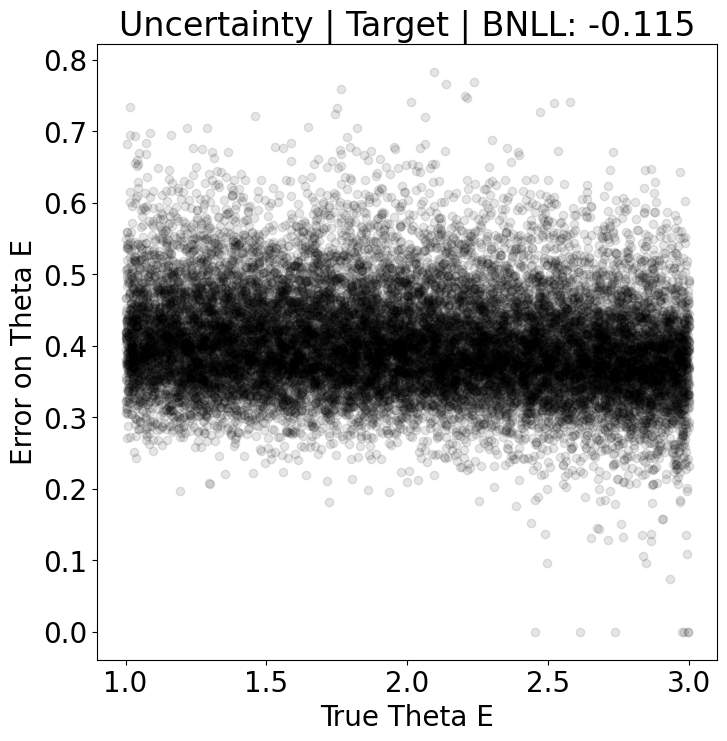

In [25]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [26]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

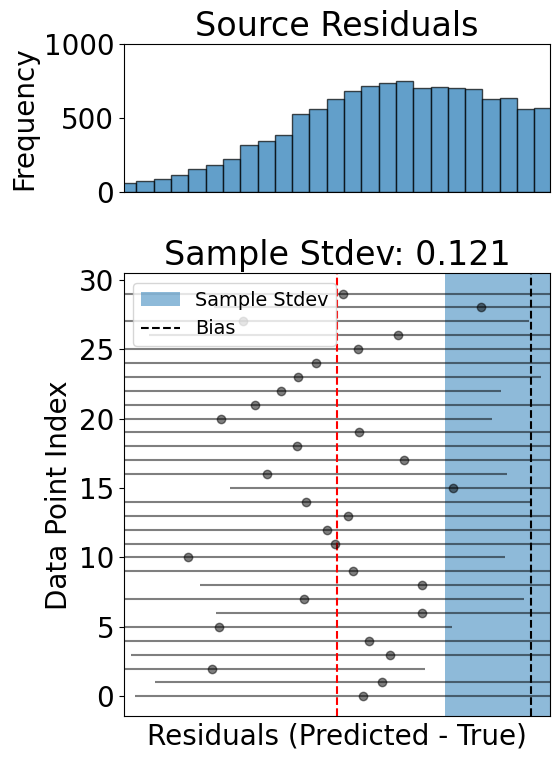

In [27]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=100, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')
ax_resid.sharex(ax_hist)
ax_hist.set_yticks([0, 500, 1000])
ax_hist.set_xticks([])
ax_hist.set_yticklabels([0, 500, 1000])


plt.xlim(-0.3, 0.3)

plt.tight_layout()
plt.show()

0.12142933422783131


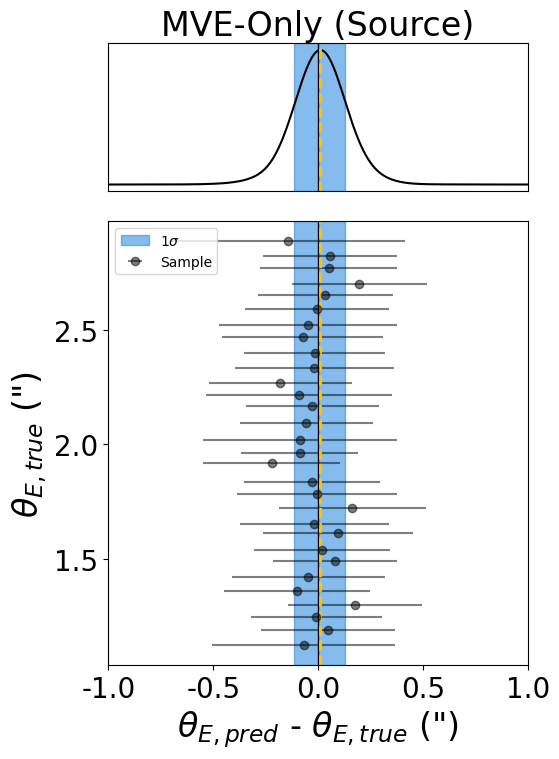

In [41]:
from scipy.stats import gaussian_kde
bins = np.linspace(1.1, 2.9, 60)
indices = np.digitize(true_source, bins) - 1 
ord_idx = np.array([np.random.choice(np.where((indices == k) & (var_preds_source > 0))[0], 1) for k in range(0, 60, 2)])
n_points = 30
rand_idx = ord_idx[:, 0]
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_source - true_source
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)
lims = 1.0

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))

kde = gaussian_kde(resid_all, bw_method=0.5)
x_vals = np.linspace(-lims, lims, 1000)
kde_values = kde(x_vals)

# Plot the histogram
ax_hist.plot(x_vals, kde_values, color = 'k')
ax_hist.set_title('MVE-Only (Source)')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=true_source[rand_idx], xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k', label = "Sample")
ax_resid.set_xlabel(r'$\theta_{E, pred}$ - $\theta_{E, true}$ (")', fontsize = 24)
ax_resid.set_ylabel(r'$\theta_{E, true}$ (")', fontsize = 24)
ax_resid.axvline(0, color = 'k', ls = '-', lw = 1)
ax_hist.axvline(0, color = 'k', ls = '-', lw = 1)

#ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_hist.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_hist.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.legend(loc = 'upper left', fontsize = 10)
#ax_resid.sharex(ax_hist)
ax_hist.set_yticks([])

xt = np.linspace(-lims, lims, 5).round(2)
ax_resid.set_xticks(xt)
ax_resid.set_xticklabels(xt)

ax_hist.set_xticks([])
ax_hist.set_yticklabels([])
ax_hist.set_xlim(-lims, lims)
ax_resid.set_xlim(-lims, lims)
print(sv)

plt.tight_layout()
plt.savefig("source_resid_noDA.png", bbox_inches = 'tight', dpi = 400)

0.3065875385066403


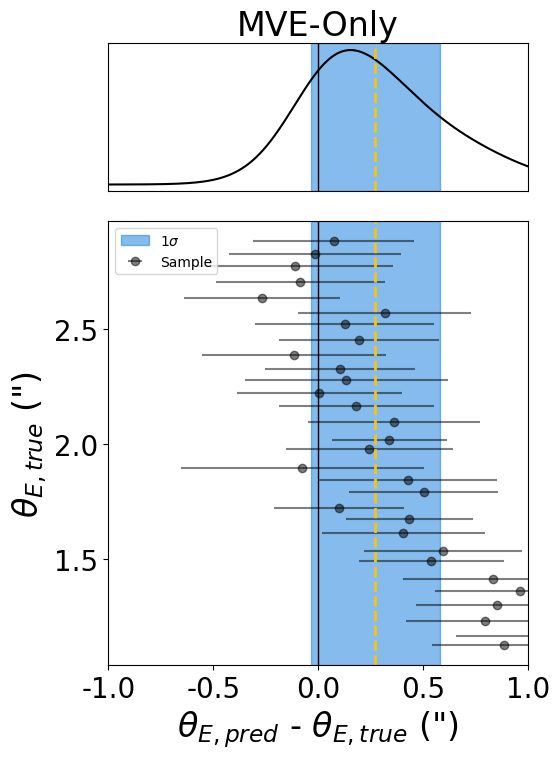

In [39]:
from scipy.stats import gaussian_kde
bins = np.linspace(1.1, 2.9, 60)
indices = np.digitize(true_target, bins) - 1 
ord_idx = np.array([np.random.choice(np.where((indices == k) & (var_preds_target > 0))[0], 1) for k in range(0, 60, 2)])
n_points = 30
rand_idx = ord_idx[:, 0]
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
lims = 1.0

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))

kde = gaussian_kde(resid_all, bw_method=0.5)
x_vals = np.linspace(-lims, lims, 1000)
kde_values = kde(x_vals)

# Plot the histogram
ax_hist.plot(x_vals, kde_values, color = 'k')
ax_hist.set_title('MVE-Only')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=true_target[rand_idx], xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k', label = "Sample")
ax_resid.set_xlabel(r'$\theta_{E, pred}$ - $\theta_{E, true}$ (")', fontsize = 24)
ax_resid.set_ylabel(r'$\theta_{E, true}$ (")', fontsize = 24)
ax_resid.axvline(0, color = 'k', ls = '-', lw = 1)
ax_hist.axvline(0, color = 'k', ls = '-', lw = 1)

#ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_hist.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "1$\sigma$", color = '#0C7BDC')
ax_hist.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.axvline(mn, color = '#FFC20A', ls = '--', lw = 2)
ax_resid.legend(loc = 'upper left', fontsize = 10)
#ax_resid.sharex(ax_hist)
ax_hist.set_yticks([])

xt = np.linspace(-lims, lims, 5).round(2)
ax_resid.set_xticks(xt)
ax_resid.set_xticklabels(xt)

ax_hist.set_xticks([])
ax_hist.set_yticklabels([])
ax_hist.set_xlim(-lims, lims)
ax_resid.set_xlim(-lims, lims)
print(sv)

plt.tight_layout()
plt.savefig("target_resid_noDA.png", bbox_inches = 'tight', dpi = 400)

In [1]:
mn

NameError: name 'mn' is not defined

In [29]:
length = len(source_data)
source_test = torch.FloatTensor(source_data[int(.7*length):int(.9*length)])
targ_test = torch.FloatTensor(target_data[int(.7*length):int(.9*length)])

In [30]:
all_cols = ['exposure_time-g',
 'numPix-g',
 'pixel_scale-g',
 'read_noise-g',
 'ccd_gain-g',
 'seeing-g',
 'magnitude_zero_point-g',
 'sky_brightness-g',
 'num_exposures-g',
'PLANE_1-OBJECT_1-REDSHIFT-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e2-g',
 'PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g',
 'PLANE_1-OBJECT_1-MASS_PROFILE_1-e1-g',
 'PLANE_1-OBJECT_1-MASS_PROFILE_1-e2-g',
 'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_x-g',
 'PLANE_1-OBJECT_1-MASS_PROFILE_1-center_y-g',
 'PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma1-g',
 'PLANE_1-OBJECT_1-SHEAR_PROFILE_1-gamma2-g',
'PLANE_2-OBJECT_1-REDSHIFT-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-center_x-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-center_y-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g',
 'PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g',
 'PLANE_2-OBJECT_1-MASS_PROFILE_1-theta_E-g',
 'PLANE_2-OBJECT_1-MASS_PROFILE_1-e1-g',
 'PLANE_2-OBJECT_1-MASS_PROFILE_1-e2-g',
 'PLANE_2-OBJECT_1-MASS_PROFILE_1-center_x-g',
 'PLANE_2-OBJECT_1-MASS_PROFILE_1-center_y-g',
'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r',
'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z',]

In [31]:
#cols = k + ['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g', 'exposure_time-g', 'read_noise-g', 'ccd_gain-g', 'seeing-g', 'sky_brightness-g', 'num_exposures-g', 'pixel_scale-g', 'magnitude_zero_point-g']


label_source = pd.read_csv(source_meta)[int(.7*length):int(.9*length)][all_cols]
label_target = pd.read_csv(target_meta)[int(.7*length):int(.9*length)][all_cols]

In [32]:
def bkg_noise(
    readout_noise, exposure_time, sky_brightness, pixel_scale, num_exposures=1
):
    """Computes the expected Gaussian background noise of a pixel in units of
    counts/second.

    :param readout_noise: noise added per readout
    :param exposure_time: exposure time per exposure (in seconds)
    :param sky_brightness: counts per second per unit arcseconds square
    :param pixel_scale: size of pixel in units arcseonds
    :param num_exposures: number of exposures (with same exposure time) to be co-added
    :return: estimated Gaussian noise sqrt(variance)
    """
    exposure_time_tot = num_exposures * exposure_time
    readout_noise_tot = num_exposures * readout_noise**2  # square of readout noise
    sky_per_pixel = sky_brightness * pixel_scale**2
    sky_brightness_tot = exposure_time_tot * sky_per_pixel
    sigma_bkg = np.sqrt(readout_noise_tot + sky_brightness_tot) / exposure_time_tot
    return sigma_bkg

In [33]:
with torch.no_grad():
    pred, _ = model(source_test.cuda())
    preds_source_test = pred[:, 0].cpu()
    var_preds_source_test = pred[:, 1].cpu()

    pred, _ = model(targ_test.cuda())
    preds_target_test = pred[:, 0].cpu()
    var_preds_target_test = pred[:, 1].cpu()

In [34]:
preds_source_test

tensor([2.6102, 2.3883, 2.8868,  ..., 0.9571, 2.0670, 2.7310])

In [35]:
var_preds_source_test

tensor([0.1828, 0.0420, 0.0692,  ..., 0.0732, 0.0414, 0.1021])

In [36]:
preds_target_test

tensor([2.7650, 1.8622, 1.8671,  ..., 1.4710, 1.6609, 1.5262])

In [37]:
var_preds_target_test

tensor([0.1347, 0.0607, 0.0304,  ..., 0.0690, 0.0563, 0.0714])

In [38]:
label_source['sig_bkg'] = bkg_noise(
    label_source['read_noise-g'], label_source['exposure_time-g'], label_source['sky_brightness-g'], label_source['pixel_scale-g'], label_source['num_exposures-g']
)

In [39]:
label_target['sig_bkg'] = bkg_noise(
    label_target['read_noise-g'], label_target['exposure_time-g'], label_target['sky_brightness-g'], label_target['pixel_scale-g'], label_target['num_exposures-g']
)

Text(0, 0.5, 'MVE Variance')

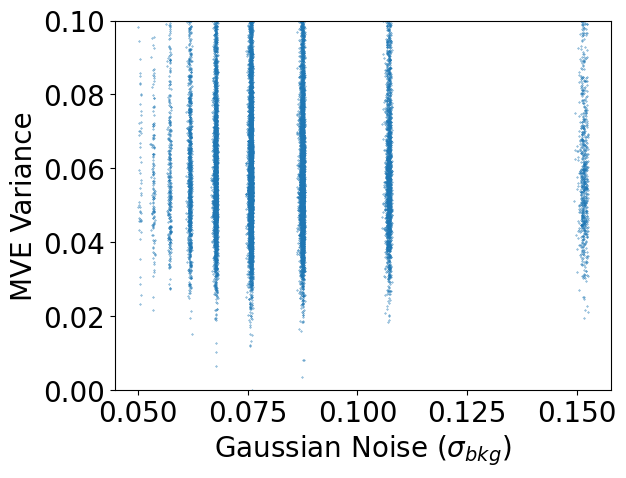

In [50]:
plt.scatter(label_target['sig_bkg'], var_preds_target_test, s = 0.1)
plt.ylim(0, 0.10)
plt.xlabel(r'Gaussian Noise ($\sigma_{bkg}$)')
plt.ylabel('MVE Variance')

Text(0, 0.5, 'MVE Variance')

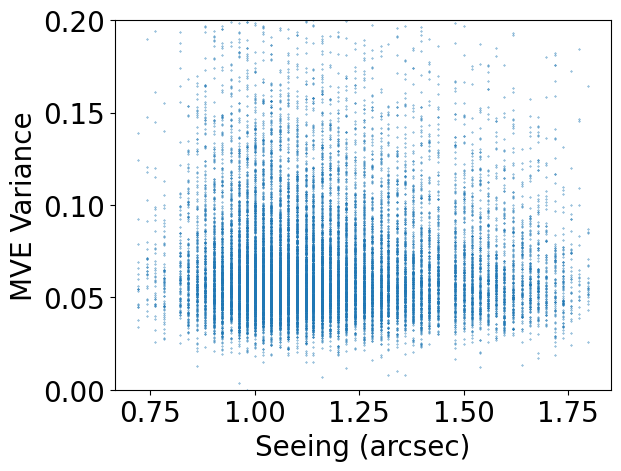

In [51]:
plt.scatter(label_target['seeing-g'], var_preds_target_test, s = 0.1)
plt.ylim(0, 0.20)
plt.xlabel('Seeing (arcsec)')
plt.ylabel('MVE Variance')

(0.0, 0.2)

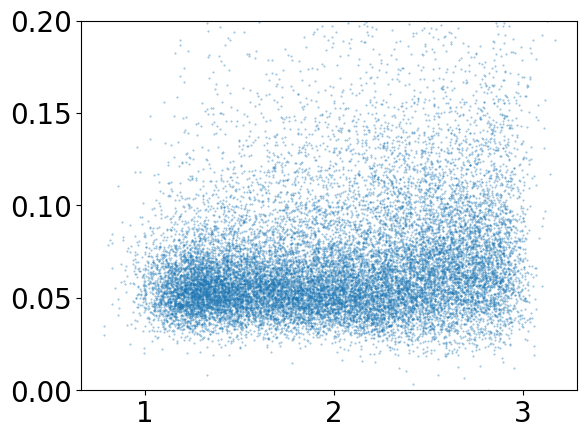

In [52]:
plt.scatter(preds_target_test, var_preds_target_test, s = 0.2, alpha = 0.5)
plt.ylim(0, 0.20)

Text(0, 0.5, 'MVE Variance')

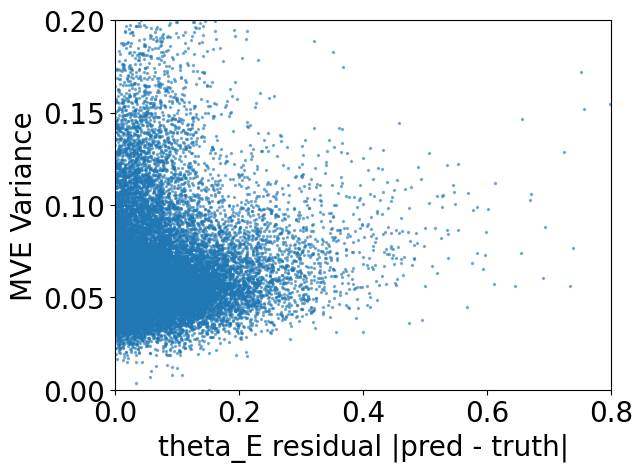

In [53]:
plt.scatter(np.abs(preds_target_test - torch.tensor(label_target['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].values)), var_preds_target_test,  alpha = 0.5, s = 2)
plt.ylim(0, 0.20)
plt.xlim(0, 0.8)
plt.xlabel("theta_E residual |pred - truth|")
plt.ylabel("MVE Variance")

In [54]:
list(pd.read_csv(source_meta).keys())

['OBJID-g',
 'H0-g',
 'Om0-g',
 'exposure_time-g',
 'numPix-g',
 'pixel_scale-g',
 'psf_type-g',
 'read_noise-g',
 'ccd_gain-g',
 'seeing-g',
 'magnitude_zero_point-g',
 'sky_brightness-g',
 'num_exposures-g',
 'NUMBER_OF_NOISE_SOURCES-g',
 'CONFIGURATION_LABEL-g',
 'CONFIGURATION_NAME-g',
 'NUMBER_OF_PLANES-g',
 'PLANE_1-NUMBER_OF_OBJECTS-g',
 'PLANE_1-OBJECT_1-NAME-g',
 'PLANE_2-NUMBER_OF_OBJECTS-g',
 'PLANE_2-OBJECT_1-NAME-g',
 'PLANE_1-OBJECT_1-REDSHIFT-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_LIGHT_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_SHEAR_PROFILES-g',
 'PLANE_1-OBJECT_1-NUMBER_OF_MASS_PROFILES-g',
 'PLANE_1-OBJECT_1-HOST-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-NAME-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_x-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-center_y-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-R_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-n_sersic-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e1-g',
 'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-e

In [55]:
idx = np.array(var_preds_target_test > 0.02)

2.55455704046247
tensor(2.1380)
tensor(0.0758)


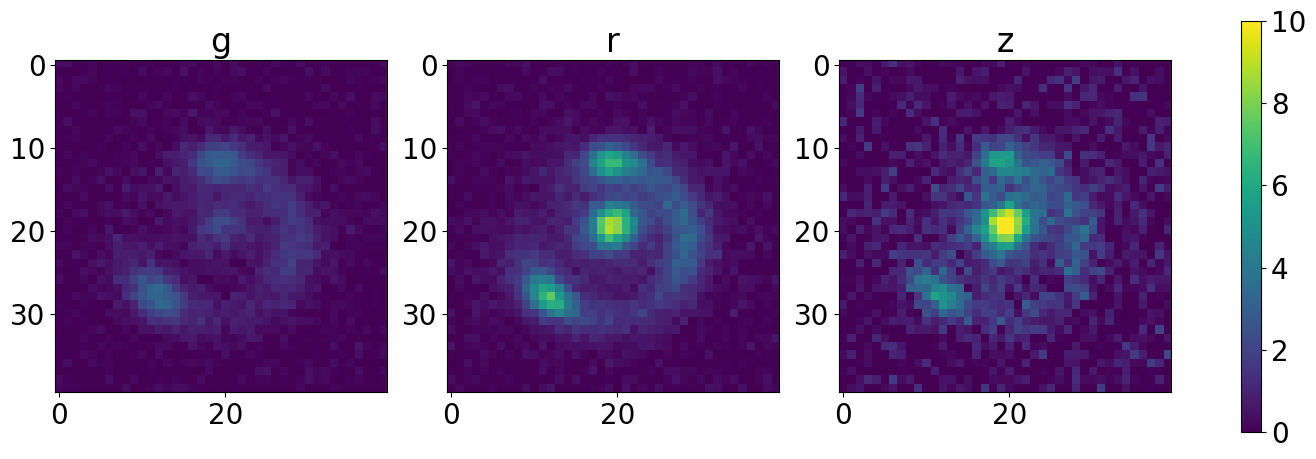

In [220]:
i = 16
img = targ_test[idx][i]

# Create a figure with 3 subplots arranged horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# First subplot
im0 = axs[0].imshow(img[0, :, :])
axs[0].set_title('g')

# Second subplot
im1 = axs[1].imshow(img[1, :, :])
axs[1].set_title('r')

# Third subplot
im2 = s = axs[2].imshow(img[2, :, :])
axs[2].set_title('z')

# Adjust layout to prevent overlap
plt.tight_layout()

vmin = 0
vmax = 10
im1.set_clim(vmin, vmax)
im2.set_clim(vmin, vmax)
im0.set_clim(vmin, vmax)

print(np.array(label_target['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'])[idx][i])
print(preds_target_test[idx][i])
print(var_preds_target_test[idx][i])
# Show the plot
plt.colorbar(s, ax = axs)
plt.show()


In [57]:
0.263 * 8.5

2.2355

In [58]:
plt.scatter(label_target[k[0]], var_preds_target_test, s = 0.1)
plt.ylim(0, 0.02)
plt.xlabel('Seeing (arcsec)')
plt.ylabel('MVE Variance')

NameError: name 'k' is not defined

In [59]:
label_target

,exposure_time-g,numPix-g,pixel_scale-g,read_noise-g,ccd_gain-g,seeing-g,magnitude_zero_point-g,sky_brightness-g,num_exposures-g,PLANE_1-OBJECT_1-REDSHIFT-g,...,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e1-g,PLANE_2-OBJECT_1-LIGHT_PROFILE_1-e2-g,PLANE_2-OBJECT_1-MASS_PROFILE_1-theta_E-g,PLANE_2-OBJECT_1-MASS_PROFILE_1-e1-g,PLANE_2-OBJECT_1-MASS_PROFILE_1-e2-g,PLANE_2-OBJECT_1-MASS_PROFILE_1-center_x-g,PLANE_2-OBJECT_1-MASS_PROFILE_1-center_y-g,PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-r,PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z,sig_bkg
69999,90,40,0.263,7,6.083,1.200,26.58,21.367,4,0.641371,...,0.131730,-0.110569,2.0,0.1,-0.1,0.0,0.0,22.168220,20.809383,0.074951
70000,90,40,0.263,7,6.083,1.101,26.58,21.823,1,0.520372,...,0.162137,-0.173192,2.0,0.1,-0.1,0.0,0.0,21.926004,20.788008,0.151067
70001,90,40,0.263,7,6.083,1.261,26.58,22.272,6,0.624346,...,0.052459,-0.111122,2.0,0.1,-0.1,0.0,0.0,21.077154,19.511723,0.062137
70002,90,40,0.263,7,6.083,1.139,26.58,22.117,5,0.506605,...,-0.071066,0.050002,2.0,0.1,-0.1,0.0,0.0,21.531065,20.429192,0.067893
70003,90,40,0.263,7,6.083,1.139,26.58,22.117,2,0.419755,...,0.176219,-0.054615,2.0,0.1,-0.1,0.0,0.0,19.053360,18.068687,0.107348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89994,90,40,0.263,7,6.083,1.101,26.58,21.823,5,0.522429,...,-0.031135,0.103990,2.0,0.1,-0.1,0.0,0.0,21.502834,20.377022,0.067559
89995,90,40,0.263,7,6.083,1.379,26.58,21.717,6,0.709645,...,0.017935,-0.158618,2.0,0.1,-0.1,0.0,0.0,18.496164,18.181974,0.061563
89996,90,40,0.263,7,6.083,1.040,26.58,21.677,4,0.564609,...,0.108741,0.036991,2.0,0.1,-0.1,0.0,0.0,22.148197,20.910866,0.075348
89997,90,40,0.263,7,6.083,0.841,26.58,22.019,3,0.287508,...,-0.085364,0.137664,2.0,0.1,-0.1,0.0,0.0,21.642292,20.085339,0.087506


In [60]:
label_target['var'] = var_preds_target_test

In [144]:
m = np.array(label_target).T

In [145]:
m.shape

(44, 20000)

In [146]:
c = np.cov(m)
good_idx = np.where(np.diag(c) != 0)
m = m[good_idx]
c = np.corrcoef(m)

In [147]:
c[-1].argmax()

30

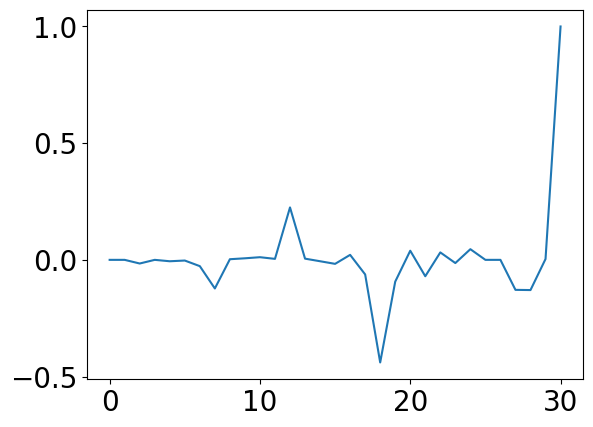

In [148]:
plt.plot(c[-1])

In [178]:
b = np.argsort(np.abs(c[-1]))

In [179]:
print(c[-1])

[ 9.15391915e-17  9.15391915e-17 -1.56655254e-02 -1.01051183e-17
 -5.99934734e-03 -2.91496049e-03 -2.69680446e-02 -1.22641384e-01
  2.72731421e-03  6.68102803e-03  1.13679861e-02  4.24707769e-03
  2.24676741e-01  5.18264486e-03 -5.93805630e-03 -1.71346727e-02
  2.13893441e-02 -6.24755195e-02 -4.39728649e-01 -9.33559672e-02
  3.91534769e-02 -7.02226358e-02  3.19222905e-02 -1.36984203e-02
  4.57177440e-02 -3.48670518e-16  3.57809060e-16 -1.28550238e-01
 -1.29451374e-01  3.47142947e-03  1.00000000e+00]


In [186]:
ci = b[-4]
ci

28

In [187]:
np.array(label_target.keys())[good_idx][ci]

'PLANE_1-OBJECT_1-LIGHT_PROFILE_1-magnitude-z'

In [188]:
c[-1][ci]

-0.12945137397603315

In [189]:
good_idx

(array([ 2,  4,  5,  6,  7,  8,  9, 13, 16, 17, 18, 19, 20, 21, 22, 25, 26,
        27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 40, 41, 42, 43]),)

(17.0, 21.0)

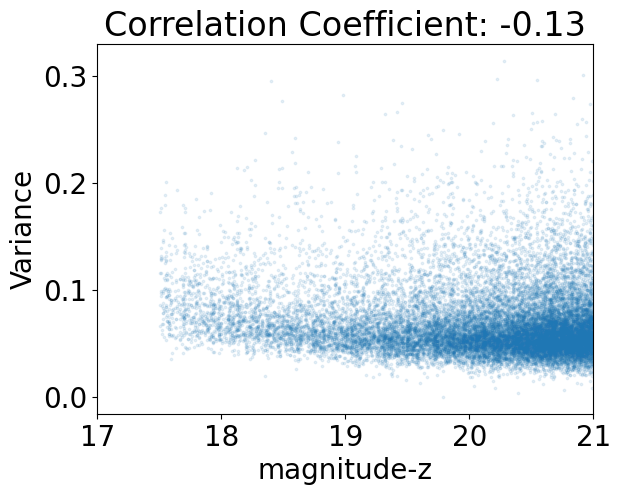

In [192]:
plt.scatter(m[ci], m[-1], alpha = 0.1, s = 3)
plt.xlabel('magnitude-z')
plt.ylabel('Variance')
plt.title('Correlation Coefficient: {:.2f}'.format(c[-1][ci]))
plt.xlim(17, 21)